In [7]:
from dataloader import TestCase
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal

test_case = TestCase("test_case0")

def filter(range,data):
    filter = np.ones(range) / range
    return np.convolve(data, filter, mode="same")

[14.70223736 13.64836145 14.15336528 13.55807854 14.21091776 12.18313821
 13.23160828 12.50747439 13.58911732]


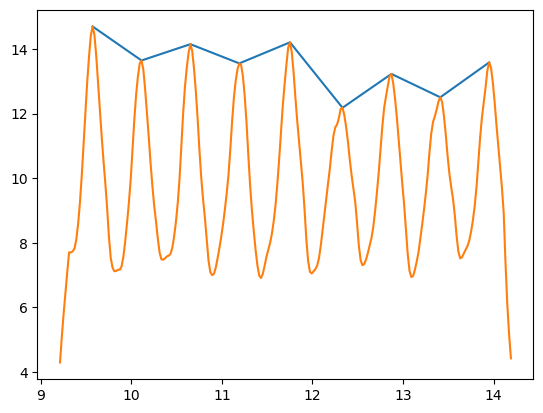

In [13]:

new_test_case = test_case.slice(10, 15)
# filtered_a = new_test_case.a_mag
filtered_a = filter(10,new_test_case.a_mag)
num_peak_3 = signal.find_peaks(filtered_a, distance=20)
print(filtered_a[num_peak_3[0]])
plt.plot(new_test_case.time[num_peak_3[0]],filtered_a[num_peak_3[0]])
plt.plot(new_test_case.time,filtered_a)
plt.show()

[94.05934403 92.19258213 90.36824664 88.44491619 86.59229642 84.52754462
 82.78806194 80.80816295 78.94140105 77.4140504 ]


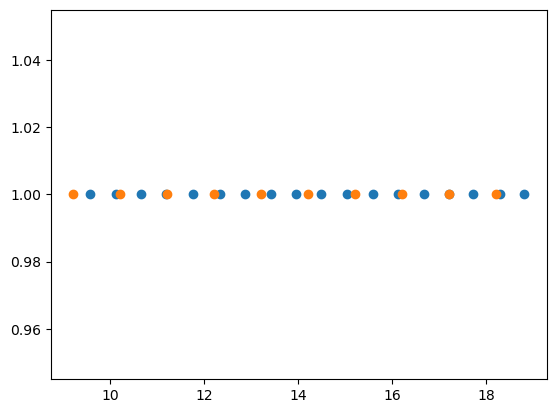

In [15]:
new_test_case = test_case.slice(10, 20)
filtered_a = new_test_case.a_mag
filtered_a = filter(10,new_test_case.a_mag)
num_peak_3 = signal.find_peaks(filtered_a, distance=20)

distance = (new_test_case.y_valid**2 + new_test_case.y_valid**2)**0.5
print(distance)
plt.scatter(new_test_case.time[num_peak_3[0]],np.ones(len(num_peak_3[0])), label="position_time")
plt.scatter(new_test_case.time_location,np.ones(len(new_test_case.x_valid)),label='step_time')
# plt.plot(new_test_case.time_location,new_test_case.x_valid)
plt.legend()
plt.show()

In [4]:
## 通过数据设置峰值阈值 lambda



def step_process_mean(test_data:TestCase):
    filtered_a = test_data.a_mag
    filtered_a = filter(10,test_data.a_mag)
    num_peak_3 = signal.find_peaks(filtered_a, distance=20)
    mean_peak = sum(filtered_a[num_peak_3[0]])/len(num_peak_3[0])
    real_peak = num_peak_3[0][np.where(filtered_a[num_peak_3[0]] > mean_peak*0.8)]
    distance = 0
    # print(len(real_peak))
    for k in range(1,len(test_data.y)):
        distance += np.sqrt((test_data.y[k] - test_data.y[k-1])**2 + (test_data.x[k] - test_data.x[k-1])**2)
    
    step_end = 0
    while test_data.time[real_peak[step_end]] < test_data.time_location[len(test_data.x)-1]:
        step_end += 1
    meanstep = distance/step_end
    print(step_end)
    return meanstep


def try_model(model:str):
    
    if model == 't':
        ####3.1决策树回归####
        from sklearn import tree
        model_output = tree.DecisionTreeRegressor()
    ####3.2线性回归####
    elif model == 'l':
        from sklearn import linear_model
        model_output = linear_model.LinearRegression()
    ####3.3SVM回归####
    elif model == 's':
        from sklearn import svm
        model_output = svm.SVR()
    ####3.4KNN回归####
    elif model == 'n':
        from sklearn import neighbors
        model_output = neighbors.KNeighborsRegressor()
    ####3.5随机森林回归####
    elif model == 'f':
        from sklearn import ensemble
        model_output = ensemble.RandomForestRegressor(n_estimators=20)#这里使用20个决策树
    ####3.6Adaboost回归####
    elif model == 'a':
        from sklearn import ensemble
        model_output = ensemble.AdaBoostRegressor(n_estimators=50)#这里使用50个决策树
    ####3.7GBRT回归####
    elif model == 'e':
        from sklearn import ensemble
        model_output = ensemble.GradientBoostingRegressor(n_estimators=100)#这里使用100个决策树
    ####3.8Bagging回归####
    elif 'b':
        from sklearn.ensemble import BaggingRegressor
        model_output = BaggingRegressor()
    ####3.9ExtraTree极端随机树回归####
    else:
        from sklearn.tree import ExtraTreeRegressor
        model_output = ExtraTreeRegressor()
    
    return model_output

def step_process_regression(test_data:TestCase,model_str):
    model = try_model(model_str)
    x = []
    y = []
    filtered_a = filter(10,test_data.a_mag)
    num_peak_3 = signal.find_peaks(filtered_a, distance=20)
    mean_peak = sum(filtered_a[num_peak_3[0]])/len(num_peak_3[0])
    real_peak = num_peak_3[0][np.where(filtered_a[num_peak_3[0]] > mean_peak*0.8)]
    
    step_index = 0
    
    distance_frac_step = 5

    for i in range(1,len(test_data.x)//distance_frac_step):
        # new_test_case = test_data.slice((i-1)*5, i*5+1)
        # filtered_a = new_test_case.a_mag
        last_step_index = step_index
        
        peak_for_i = []
        while test_data.time[real_peak[step_index]] <= test_data.time_location[i*distance_frac_step]:
            step_index += 1

        distance = 0
        for k in range((i-1)*distance_frac_step,i*distance_frac_step):
            distance += np.sqrt((test_data.y[k+1] - test_data.y[k])**2 + (test_data.x[k+1] - test_data.x[k])**2)
        
        y.append([distance/(step_index - last_step_index)])

        f = (step_index - last_step_index)/( test_case.time[real_peak[step_index]] - test_case.time[real_peak[last_step_index]])
        print(f)
        sigma = np.var(filtered_a[real_peak[last_step_index]:real_peak[step_index+1]])
        # print(sigma)
        x.append([f,sigma])
    
    model.fit(x,y)
    # sum_up = 0
    for i in range(len(y)):
        print(y[i],model.predict([x[i]])[0])
    #     sum_up += y[i][0]
    
    # print(sum_up/len(y))
    # # print("w值为:",model.coef_)
    # # print("b截距值为:",model.intercept_)
    return model


# step_process_regression(test_case)

meanstep = step_process_mean(test_case)


106


In [5]:
model = step_process_regression(test_case,'l')
filtered_a = filter(10,test_case.a_mag)
num_peak_3 = signal.find_peaks(filtered_a, distance=20)
mean_peak = sum(filtered_a[num_peak_3[0]])/len(num_peak_3[0])
real_peak = num_peak_3[0][np.where(filtered_a[num_peak_3[0]] > mean_peak*0.8)]

test_begin = len(test_case.x)
step_test_begin = 0
while test_case.time[real_peak[step_test_begin]] < test_case.time_location[test_begin]:
    step_test_begin += 1


1.8025484251563353
1.8145289714536317
1.829273239870001
1.836736968570334
1.8518541653864642
1.851852947146587
1.8218618213992037
1.8367361515621536
1.7999999619428582
1.7857143700252256
1.807227965316399
[1.7126756394611733] [0.93382723]
[0.7831658078318107] [0.87107363]
[0.7541958725399203] [0.83254657]
[0.7151374915720784] [0.79664072]
[0.7423318920270637] [0.72333203]
[0.6875759072471757] [0.71843631]
[1.020229063480331] [0.84084373]
[0.7289020115022786] [0.77958133]
[0.7417518358520645] [0.93824656]
[0.7019459447109564] [0.99934644]
[0.767222781829604] [0.92125969]


In [6]:
real_distance = 0
test_distance = 0

for i in range(len(test_case.x),(len(test_case.x_valid)-len(test_case.x))):
    real_distance += np.sqrt((test_case.y_valid[i+1] - test_case.y_valid[i])**2 + (test_case.x_valid[i+1] - test_case.x_valid[i])**2)

print(real_distance)
# print(np.var(filtered_a))
for i in range(step_test_begin,len(real_peak)):
    f = 1/( test_case.time[real_peak[i]] - test_case.time[real_peak[i-1]])
    sigma = np.var(filtered_a[real_peak[i-1]:real_peak[i]])
    # print(f)
    # print(filtered_a[real_peak[i-1]:real_peak[i]])
    # print(sigma)
    # print(f,sigma)
    test_distance += model.predict([[f,sigma]])[0]
print(meanstep * (len(real_peak) - step_test_begin + 2))
print(step_test_begin)
print(len(real_peak))
print(test_distance)

628.6834101596158
840.3455228562558
108
1117
[698.92958401]
